# Structure of project

Our project is structured as follows:

1. code/ -> For all needed scripts and code

2. data/ -> For all databases and datasets needed
     1. data/msa/ -> For the MSA extracted in steps 3, 4 of Building the models
     
     
3. tools/ -> For tools like hmmer, psiblast, tmalign

4. figs/ -> For various plots and figures

# Our sequence

We saved our assigned sequence in data/domain.fasta

In [14]:
%config Completer.use_jedi = False

# Building the models
## 1. Defining the Ground Truth

Using the InterPro Api, we were able to retrieve all proteins in SwissProt with our assigned Pfam domain and the domain positions. The script that does this is get_pfam_domains.py

In [1]:
!python3 get_pfam_domains.py https://www.ebi.ac.uk/interpro/api/protein/reviewed/entry/pfam/PF00483/ ../data/reviewed_domain_positions.csv

Pages parsed: 0
Pages parsed: 10
Pages parsed: 20
Total pages parsed: 30


## 2. Retrieving Homologous proteins

Starting from our input sequence stored in data/domain.fasta we performed a blast search against UniRef50 and stored the homologous proteins in formated_blastp.out

In [ ]:
!../tools/ncbi-blast-2.11.0+/bin/blastp -query ../data/domain.fasta -db data/uniref50.fasta -outfmt "6 sseqid" > ../data/formated_blastp.out

## 3/4. Generating Multiple Sequence alignment on the hits returned.

Here we used ebi alignment services and generated 16 MSAs that are stored in the data/ folder. The naming convention used is UR50_XX_RYY.fasta. where XX is the alignment algorithm used, MU for Muscle, TC for t-coffee and CO for Clustal Omega. YY is for the threshold we set for removing the redundant sequences for the alignment

## 5/6. Building PSSM and HMM models starting from the MSA

Here we considered an automated approach to generate multiple models and see how they perform given the initial MSA. For each of the 16 MSAs at the beggining we generated one PSSM and one HMM models. Then we preformed hmmsearch and psiblast accordingly to find significant hits against SwissProt. The script that accomplishes this is utils.py which contains all the needed functions and it is all wrapped up in the following three lines of code.

In [4]:
from utils import *

In [ ]:
for msa in os.listdir('../data/msa/'):
    complete_analysis_hmm(msa, msa.split('.')[0])
    complete_analysis_pssm(msa, msa.split('.')[0])

## 7/8. Evaluating the performance of the models.

In [7]:
import glob

hmm_sequence_metrics = []
hmm_position_metrics = []

for model in glob.glob('../models/hmm/*'):
    with open(model+'/sequences_metrics.json') as f:
        model_sequence_metrics = json.load(f)
    with open(model+'/positions_metrics.json') as f:
        model_position_metrics = json.load(f)
    model_sequence_metrics['model_name'] = model.split('.')[-1]
    model_position_metrics['model_name'] = model.split('.')[-1]
    
    hmm_sequence_metrics.append(model_sequence_metrics)
    hmm_position_metrics.append(model_position_metrics)

hmm_sequence_metrics_df = pd.DataFrame(hmm_sequence_metrics)
hmm_position_metrics_df = pd.DataFrame(hmm_position_metrics)

pssm_sequence_metrics = []
pssm_position_metrics = []

for model in glob.glob('../models/pssm/*'):
    with open(model+'/sequences_metrics.json') as f:
        model_sequence_metrics = json.load(f)
    with open(model+'/positions_metrics.json') as f:
        model_position_metrics = json.load(f)
    model_sequence_metrics['model_name'] = model.split('.')[-1]
    model_position_metrics['model_name'] = model.split('.')[-1]
    
    pssm_sequence_metrics.append(model_sequence_metrics)
    pssm_position_metrics.append(model_position_metrics)

pssm_sequence_metrics_df = pd.DataFrame(pssm_sequence_metrics)
pssm_position_metrics_df = pd.DataFrame(pssm_position_metrics)

### Side by side comparison

In [11]:
pd.concat([hmm_sequence_metrics_df.iloc[:8], pssm_sequence_metrics_df.iloc[:8]]).sort_index()

,TP,TN,FP,FN,accuracy,precision,sensitivity,specificity,MMC,f1_score,model_name
0,561,563411,871,20,0.998423,0.391760,0.965577,0.998456,0.614588,0.557377,/models/hmm/UR50_CO_R96
0,571,563401,929,10,0.998338,0.380667,0.982788,0.998354,0.611158,0.548775,/models/pssm/UR50_CO_R96
1,563,563409,2365,18,0.995792,0.192281,0.969019,0.995820,0.430801,0.320889,/models/hmm/UR50_CO_R98
1,566,563406,934,15,0.998320,0.377333,0.974182,0.998345,0.605810,0.543969,/models/pssm/UR50_CO_R98
2,563,563409,2153,18,0.996165,0.207290,0.969019,0.996193,0.447377,0.341523,/models/hmm/msa_modified_clustalomega
2,572,563400,928,9,0.998341,0.381333,0.984509,0.998356,0.612227,0.549736,/models/pssm/msa_modified_clustalomega
3,562,563410,878,19,0.998412,0.390278,0.967298,0.998444,0.613966,0.556160,/models/hmm/UR50_MU_R92
3,572,563400,928,9,0.998341,0.381333,0.984509,0.998356,0.612227,0.549736,/models/pssm/UR50_MU_R92
4,549,563423,825,32,0.998483,0.399563,0.944923,0.998538,0.614042,0.561637,/models/hmm/UR50_MU_R95
4,563,563409,937,18,0.998310,0.375333,0.969019,0.998340,0.602601,0.541086,/models/pssm/UR50_MU_R95


In [12]:
pd.concat([hmm_position_metrics_df.iloc[:8], pssm_position_metrics_df.iloc[:8]]).sort_index()

,TP,TN,FP,FN,accuracy,precision,sensitivity,specificity,MMC,f1_score,model_name
0,132828,202938645,76486,37284,0.999440,0.634587,0.780827,0.999623,0.703797,0.700152,/models/hmm/UR50_CO_R96
0,139938,202984487,60376,442,0.999701,0.698593,0.996851,0.999703,0.834378,0.821488,/models/pssm/UR50_CO_R96
1,134476,202911886,83960,54921,0.999316,0.615631,0.710022,0.999586,0.661030,0.659466,/models/hmm/UR50_CO_R98
1,138590,202986538,59787,328,0.999704,0.698619,0.997639,0.999706,0.834724,0.821773,/models/pssm/UR50_CO_R98
2,131643,202851947,82584,119069,0.999008,0.614502,0.525077,0.999593,0.567959,0.566281,/models/hmm/msa_modified_clustalomega
2,139861,202986197,58666,519,0.999709,0.704494,0.996303,0.999711,0.837667,0.825365,/models/pssm/msa_modified_clustalomega
3,112903,202833918,67255,171167,0.998827,0.626689,0.397448,0.999669,0.499033,0.486412,/models/hmm/UR50_MU_R92
3,137641,202990562,56674,366,0.999719,0.708340,0.997348,0.999721,0.840395,0.828359,/models/pssm/UR50_MU_R92
4,108368,202839413,72078,165384,0.998831,0.600556,0.395862,0.999645,0.487562,0.477184,/models/hmm/UR50_MU_R95
4,133064,203042533,8891,755,0.999953,0.937367,0.994358,0.999956,0.965420,0.965022,/models/pssm/UR50_MU_R95


# Domain Family Characterization

We have chosen the hmm model built upon the T-Coffee alignment and will procede the analysis using it as a basis for further enquiries about the main function of the family.

## 1. Dataset Definitions
### Family Structures

Using HMMSearch we at https://www.ebi.ac.uk/Tools/hmmer/search/hmmsearch against the pdb database we obtain the chains significantly matching our model and saved it in data/pdb_chains.tsv

In [14]:
pdb_chains = pd.read_csv('../data/pdb_chains.tsv', delimiter='\t')
pdb_chains.head()

,Target Name,Target Accession,Target Length,Query Name,Query Accession,Query Length,E-value,Score,Bias,Domain Index,...,Query Ali. Start,Query Ali. End,Target Ali. Start,Target Ali. End,Target Env. Start,Target Env. End,Acc,Description,Mapped PDB(s),Number of Identical Sequences
0,5xhw_A,5xhw_A,237,UR50_TC,-,272,3.800000e-82,279.7,0.1,1,...,1,232,13,237,11,237,0.97,Putative 6-deoxy-D-mannoheptose pathway protein,5xhw_A,0
1,1tzf_A,1tzf_A,259,UR50_TC,-,272,6.800000e-45,157.5,0.1,1,...,1,220,1,237,1,245,0.86,Glucose-1-phosphate cytidylyltransferase,1tzf_A,1
2,4y7t_A,4y7t_A,231,UR50_TC,-,272,4.900000e-43,151.4,0.0,1,...,1,235,1,223,1,230,0.88,Nucleotidyl transferase,4y7t_A,2
3,5z09_A,5z09_A,409,UR50_TC,-,272,1.300000e-38,136.9,0.1,1,...,1,240,1,231,1,305,0.85,Dual sugar-1-phosphate nucleotidylyltransferase,5z0a_A,11
4,2ggo_A,2ggo_A,401,UR50_TC,-,272,5.900000e-37,131.5,0.1,1,...,1,240,1,231,1,304,0.85,401aa long hypothetical glucose-1-phosphate th...,2ggo_A,1


We can now calculate the overlap percentage and discard unsatisfactory chains. We obtain the .ent files and store them in data/pdb/pdb_ents/

In [16]:
def calculate_overlap(row):
    qas = row['Query Ali. Start']
    qae = row['Query Ali. End']
    tas = row['Target Ali. Start']
    tae = row['Target Ali. End']
    
    if qae <= tas or qas>=tae:
        return 0

    mins = max(qas, tas)
    maxs = min(qae, tae)

    return (maxs-mins)/(max(qae, tae) - min(qas, tas))

pdb_chains['overlap'] = pdb_chains.apply(calculate_overlap, axis=1)

In [17]:
from Bio.PDB import PDBList, is_aa, PDBIO
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import IUPACData
from Bio.PDB.PDBIO import Select
from Bio.SeqIO.PdbIO import PdbSeqresIterator

In [22]:
pdb_chains_50 = pdb_chains.sort_values(by='overlap', ascending=False).iloc[:50]
ids = pdb_chains_50['Target Name']

pdbl = PDBList()

for id in ids:
    pdbl.retrieve_pdb_file(id.split('_')[0], pdir='../data/pdb/pdb_ents', file_format='pdb')

## 1. All-vs-All pariwise structural Alignment

Using TM-align we perform an AvA structural alignment and store the results in data/pdb/pdb_alignments/

In [ ]:
sf = pd.DataFrame(data=[id.split('_')[0] for id in ids.values], columns=['pdb_id'])

for a, pdbA in enumerate(sf.pdb_id):
    for b, pdbB in enumerate(sf.pdb_id):
        print(a, b)
        statement = "../tools/TMalign "
        statement += f"../data/pdb/pdb_ents/pdb{pdbA}.ent "
        statement += f"../data/pdb/pdb_ents/pdb{pdbB}.ent "
        statement += f"-o ../data/pdb/pdb_alignments/{pdbA}_{pdbB}.sup "
        statement += f"> ../data/pdb/pdb_alignments/{pdbA}_{pdbB}.out"

        os.system(statement)

## 2. Pairwise RMSD

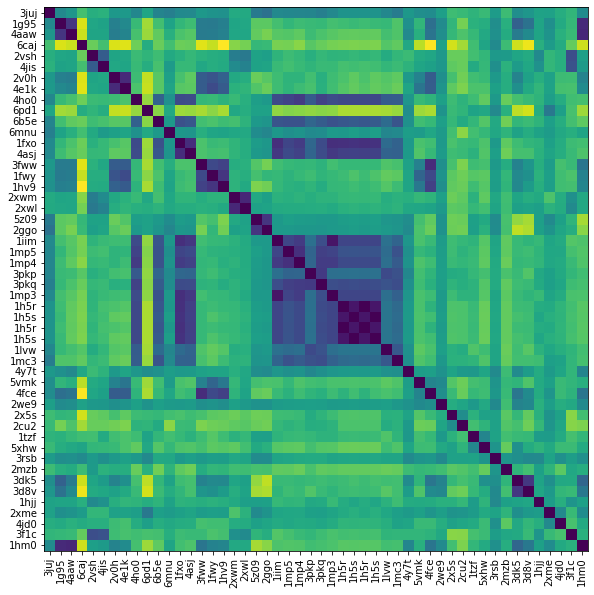

In [76]:
import numpy as np
import re
import matplotlib.pyplot as plt

sf = pd.DataFrame(data=[id.split('_')[0] for id in ids.values], columns=['pdb_id'])

iden = np.zeros((len(sf), len(sf)))
rmsd = np.zeros((len(sf), len(sf)))

for a, pdbA in enumerate(sf.pdb_id):
    for b, pdbB in enumerate(sf.pdb_id):

        with open(f"../data/pdb/pdb_alignments/{pdbA}_{pdbB}.out", "r") as f:
            line = f.readlines()[16]
            
        eqs = list(re.finditer("=", line))
        cms = list(re.finditer(",", line))
        
        rmsd[a, b] = float(line[eqs[1].span()[1]: cms[1].span()[0]])

fig, ax = plt.subplots(figsize=(10, 10))
plt.xticks(ticks = np.arange(0, 50, step=1), labels=sf['pdb_id'].values, rotation=90)
plt.yticks(ticks = np.arange(0, 50, step=1), labels=sf['pdb_id'].values)
im = ax.imshow(rmsd)

plt.savefig('../figs/rmsd.jpg', format='jpg')

## 3/4. Dendrogram + Remove Outliers

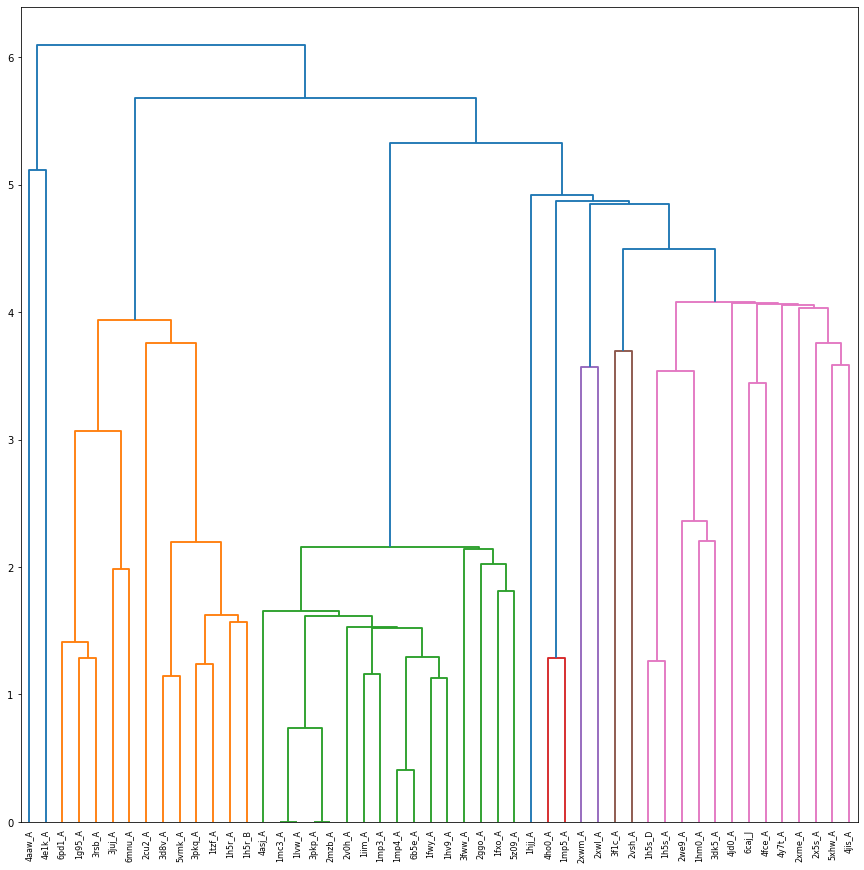

In [43]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(15, 15))
x = dendrogram(linkage(rmsd))
x = dendrogram(linkage(rmsd), labels=[pdb_chains_50.iloc[int(m)]['Target Name'] for m in x['ivl']])
plt.savefig('../figs/dendrogram.jpg', format='jpg')
pass

We can now see whether we have outliers in our set and remove them.

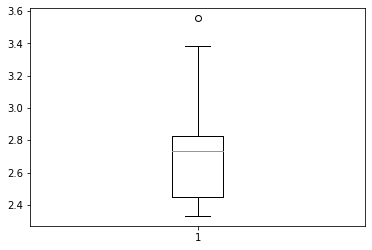

In [42]:
rm_means = [(i, rmsd[i, :].mean()) for i in range(50)]
labels = [pdb_chains_50.iloc[i]['Target Name'] for i in range(50)]
plt.boxplot([b for a, b in rm_means])
print()

In [51]:
print(f'The outlier has id: {pdb_chains_50.iloc[3]["Target Name"]}')

The outlier has id: 6caj_J


## 5. mTM-align
Due to the limitations of the mTM-align software we were confined to using only 30 PDBs. We will zip the first 30 by overlap and save the results obtained in data/pdb/ (Both the full and common core regions).

In [71]:
from zipfile import ZipFile

chains_to_process = ['../data/pdb/pdb_ents/pdb' + p.split('_')[0] + '.ent' for p in pdb_chains_50.sort_values(by='overlap', ascending=False)['Target Name'][:30].values]

with ZipFile('../data/to_mtmalign.zip', 'w') as myzip:
    for chain in np.unique(chains_to_process):
        myzip.write(chain)

In [72]:
from Bio.PDB import PDBList, NeighborSearch
from Bio.PDB.PDBParser import PDBParser

def get_distance_matrix(residues, seq_sep=6):

    # Calculate the distance matrix
    distances = []
    for residue1 in residues:
        if residue1.id[0] == " ":  # Exclude hetero/water residues
            row = []
            for residue2 in residues:
                if residue2.id[0] == " ":  # Exclude hetero/water residues
                    if abs(residue1.id[1] - residue2.id[1]) >= seq_sep:
                        row.append(residue1["CA"] - residue2["CA"])
                    else:
                        row.append(None)
            distances.append(row)

    return np.array(distances, dtype=float)

## 6/7. Identifying conserved positions and contacts

We will mainly work with the common core alignment from data/pdb/mtmalign/cc.pdb

In [73]:
structure = PDBParser(QUIET=True).get_structure("common_core", "../data/pdb/mtmalign/cc.pdb")
chains = structure[0]

In [79]:
distance_matrices = [get_distance_matrix(chain, 12) for chain in chains]
len(distance_matrices)

29

Plotting a smaller sample from the distance matrices.

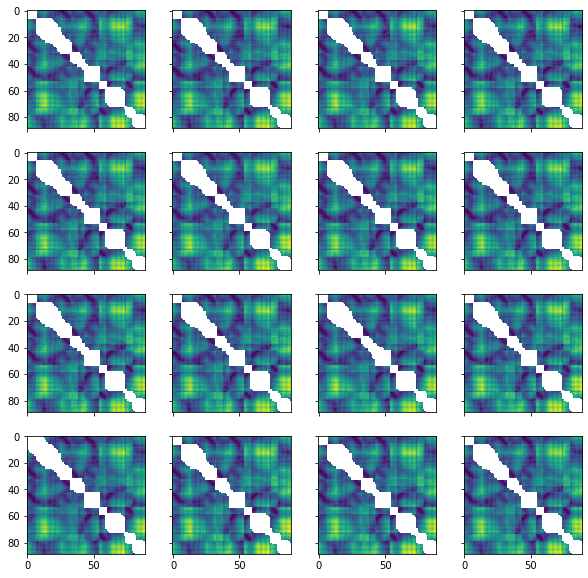

In [83]:
import seaborn as sns

ncols = 4
nrows = 4

fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(10, 10))

for i, dm in enumerate(distance_matrices[:16]):
    ax[i//4][i%4].imshow(dm)

plt.savefig("figs/distance_matrices.pdf", bbox_inches='tight')

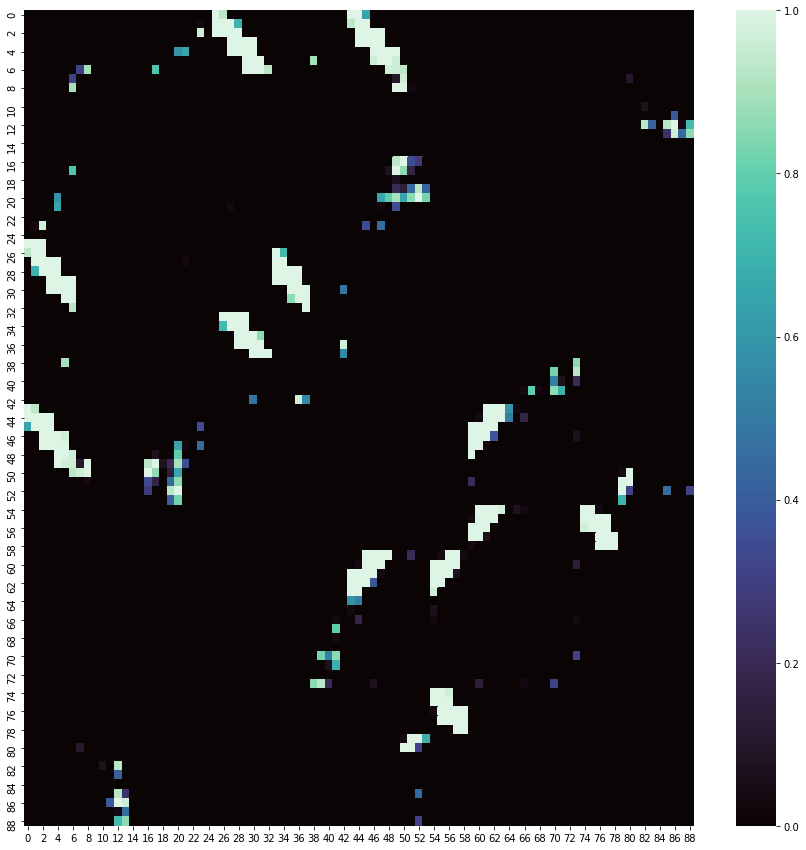

In [85]:
contact_map = [(mat < 8).astype(float) for mat in distance_matrix]

avg_contact = np.mean(contact_map, axis=0)
plt.figure(figsize=(15, 15))
_ = sns.heatmap(avg_contact, cmap='mako')

plt.savefig("figs/contact_map.pdf", bbox_inches='tight')

# Taxonomy

Using the script code/retrieving_family_sequences.py we retrieve the xml of our sequences to analyze the taxonomy. We store it in data/family_sequences.xml

In [ ]:
!python3 ../code/retrieve_family_sequences.py

Firstly we needed to analyze the xml file to see how to retrieve our needed data. Below we show a sample entry

In [86]:
from lxml import etree

tree = etree.parse("../data/family_sequences.xml")

root = tree.getroot()
namespaces = root.nsmap

for child in root.getchildren()[:3]:
    all_elements = child.findall('*', namespaces)
    print(child.keys())
    print(child.values())
    for element in all_elements:
        db_references = element.findall('*', namespaces)
        print('\t', element.keys())
        print('\t', element.values())
        for db_reference in db_references:
            print('\t\t', db_reference.keys())
            print('\t\t', db_reference.values())
            for fin in db_reference.findall('*', namespaces):
                #if 'NCBI taxonomy' not in fin.values():
                #    continue
                print('\t\t\t', fin.keys())
                print('\t\t\t', fin.values())
    break

['id', 'updated']
['UniRef90_Q9AGY6', '2013-10-16']
	 []
	 []
	 ['type', 'value']
	 ['member count', '1']
	 ['type', 'value']
	 ['common taxon', 'Aneurinibacillus thermoaerophilus']
	 ['type', 'value']
	 ['common taxon ID', '143495']
	 ['type', 'value']
	 ['GO Molecular Function', 'GO:0005525']
	 ['type', 'value']
	 ['GO Molecular Function', 'GO:0016779']
	 ['type', 'value']
	 ['GO Biological Process', 'GO:0009058']
	 ['type', 'value']
	 ['GO Biological Process', 'GO:0005975']
	 ['type', 'value']
	 ['GO Biological Process', 'GO:0045232']
	 []
	 []
		 ['type', 'id']
		 ['UniProtKB ID', 'HDDC_ANETH']
			 ['type', 'value']
			 ['UniProtKB accession', 'Q9AGY6']
			 ['type', 'value']
			 ['UniParc ID', 'UPI00000BBF85']
			 ['type', 'value']
			 ['UniRef100 ID', 'UniRef100_Q9AGY6']
			 ['type', 'value']
			 ['UniRef50 ID', 'UniRef50_Q9AGY6']
			 ['type', 'value']
			 ['protein name', 'D-glycero-alpha-D-manno-heptose 1-phosphate guanylyltransferase']
			 ['type', 'value']
			 ['source organis

In [104]:
taxo_ids = []

for cluster in root.getchildren():
    for prop in cluster.findall("*", namespaces):
        if prop.get("type") == "common taxon ID":
            taxo_ids.append(prop.get("value"))

Now we can retrieve the taxonomic lineage for each protein in our dataset

In [87]:
from ete3 import NCBITaxa
import toytree
import toyplot.pdf

ncbi = NCBITaxa()
ncbi.update_taxonomy_database()

Updating taxdump.tar.gz from NCBI FTP site (via HTTP)...
Done. Parsing...


Loading node names...
2308071 names loaded.
241364 synonyms loaded.
Loading nodes...
2308071 nodes loaded.
Linking nodes...
Tree is loaded.
Updating database: /home/danailkrzhalovski/.etetoolkit/taxa.sqlite ...
 2308000 generating entries... 1570000 generating entries... 
Uploading to /home/danailkrzhalovski/.etetoolkit/taxa.sqlite


Inserting synonyms:      20000 

Inserting taxid merges:  45000  

Inserting taxids:       30000  

Inserting taxids:       2305000 

In [105]:
tree = ncbi.get_topology(taxo_ids)
tree.write(features=[], format=2, outfile="../data/taxonomic_lineage_tree.nh")

with open("../data/lineages.csv", "w") as f:
    for taxo_id in taxo_ids:
        lineage = ncbi.get_lineage(taxo_id)
        translation = ncbi.translate_to_names(lineage)
        f.write(",".join(translation) + "\n")

In [106]:
tree = toytree.tree("../data/taxonomic_lineage_tree.nh", tree_format=0)

In [133]:
from collections import Counter

abundance_counter = Counter(taxo_ids)
relative_sizes = [abundance_counter[node[1].name] for node in tree.idx_dict.items()]

In [145]:
canvas, _, _ = tree.draw(
    tree_style='c',
    layout='d',
    height=1000,
    scalebar=False,
    node_labels = relative_sizes,
    node_sizes = np.array(relative_sizes)*2,
    edge_type = 'p',
    edge_style={"stroke-width": 0.5},
    edge_align_style={"stroke": "black", "stroke-dasharray": 1, "stroke-width": 0.2},
)
pass

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1000.0px" height="1000.0px" viewBox="0 0 1000.0 1000.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="ta2472bd19bea4a8baa8919d8b6c58f0e"> 1 1 2 1 1 1 1 1 1 1 1 1 1 1 9 1 2 2 2 1 1 1 1 1 2 1 1 1 2 1 1 1 1 2 1 1 1 1 2 2 1 1 2 1 1 1 2 1 1 1 2 1 1 1 1 3 1 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 2 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 1 3 1 3 1 1 1 2 1 1 1 1 2 3 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 3 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 6 3 1 1 1 1 2 1 1 1 1 1 2 1 1 2 2 1 2 1 1 2 1 1 1 1 5 2 2 3 2 2 1 2 1 2 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 3 1 1 1 1 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 0 2 3 11 0 10 1 5 4 1 4 3 2 0 2 1 2 0 0 1 5 1 2 0 0 2 0 2 1 1 0 0 0 0 4 6 2 0 10 4 0 3 0 1 0 0 2 1 1 1 1 2 5 1 3 2 1 1 1 2 1 1 1 0 0 2 7 2 5 2 0 1 0 0 0 1 0 0 0 0 0 1 4 1 1 1 4 0 2 5 0 1 3 3 1 1 1 0 2 0 0 1 2 1 1 1 2 4 2 7 0 0 0 0 2 0 1 0 0 6 0 2 0 0 1 0 0 1 1 2 3 0 2 1 2 1 2 0 0 0 0 0 0 1 2 0 2 0 1 9 1 0 2 1 1 3 0 0 0 1 0 0 1 0 0 0 14 6 0 0 0 0 0 0 1 1 0 1 39 0 0 7 0

In [147]:
toyplot.pdf.render(canvas, "../figs/taxonomic_lineage_tree.pdf")

In [155]:
most_common = abundance_counter.most_common(15)

for item in most_common:
    for _, node in tree.idx_dict.items():
        if node.name == item[0]:
            print(node.sci_name, item[1])

Bacteria 39
Proteobacteria 14
Clostridium 11
Streptococcus 10
Mycobacteriaceae 10
Gammaproteobacteria 9
Shewanella 9
Vibrionaceae 7
cellularorganisms 7
Pasteurellaceae 7
Streptomyces 6
Bacillaceae 6
Terrabacteriagroup 6
Rhizobiales 6


# Functional Characterization

## 10. Collecting GO annotation
We already have our family sequences in xml format from the last part so we can just retrieve the GO annotations easily

In [1]:
from lxml import etree
import pandas as pd
import numpy as np

tree = etree.parse("../data/family_sequences.xml")

root = tree.getroot()
namespaces = root.nsmap

go_dict={}

for cluster in root.getchildren():
    go_dict[cluster.get("id")[9:]]=[]
    for prop in cluster.findall("property", namespaces):
        if prop.get("type").startswith("GO"):
            go_dict[cluster.get("id")[9:]].append(prop.get("value"))

## 11. Calculating Enrichment

To do this we need also the annotations from the SwissProt dataset, which we collect with the script retrieve_sp_annotations.py into ../data/SwissProt/anntations.json. We also need some helper functions to parse the go and obo data.

In [ ]:
!python3 retrieve_sp_annotations.py

In [2]:
def parse_obo(obo_file):
    # Parse the ontology, exclude obsolete terms
    graph = {}  # { term_id : term_object }
    obj = {}  # { id: term_id, name: definition, is_a: list_of_parents, is_obsolete: True, namespace: namespace }
    with open(obo_file) as f:
        for line in f:
            line = line.strip().split(": ")
            if line and len(line) > 1:
                # print(line)
                k, v = line[:2]
                if k == "id" and v.startswith("GO:"):
                    obj["id"] = v
                elif k == "name":
                    obj["def"] = v
                elif k == "is_a" and v.startswith("GO:"):
                    obj.setdefault("is_a", []).append(v.split()[0])
                elif k == "is_obsolete":
                    obj["is_obsolete"] = True
                elif k == "namespace":
                    obj["namespace"] = v
            else:
                if obj.get("id") and not obj.get("is_obsolete"):
                    if "is_a" not in obj:
                        obj["is_root"] = True
                    graph[obj["id"]] = obj
                    # print(obj)
                obj = {}
    return graph


def get_ancestors(graph):
    """
    Build a dictionary of ancestors
    and calculate term depth (shortest path)
    """

    roots = set()
    for node in graph:
        if graph[node].get("is_root"):
            roots.add(node)

    depth = {}
    ancestors = {}  # { term : list_of_ancestor_terms }
    for node in graph:
        c = 0
        node_ancestors = []
        node_parents = graph[node].get("is_a")

        # Loop parents levels (parents of parents) until no more parents
        while node_parents:
            c += 1

            # Set root
            if node not in depth and roots.intersection(set(node_parents)):
                depth[node] = c

            # Add ancestors
            node_ancestors.extend(node_parents)

            # Update the list of parents (1 level up)
            node_parents = [term for parent in node_parents for term in graph[parent].get("is_a", [])]

        ancestors[node] = set(node_ancestors)
    return ancestors, depth, roots


def get_children(ancestors):
    children = {}  # { node : list_of_children }, leaf terms are not keys
    for node in ancestors:
        for ancestor in ancestors[node]:
            children.setdefault(ancestor, set()).add(node)
    return children

In [3]:
import fisher
import json
import copy

graph = parse_obo("../data/go.obo")
ancestors, depth, roots = get_ancestors(graph)
children = get_children(ancestors)

with open("../data/SwissProt/annotations.json", "r") as f:
    go_sp = json.load(f)

In [4]:
terms_set = {}
terms_rest = {} 
proteins_set = 0
proteins_rest = 0
    
for acc, annotations in go_sp.items():
    terms = copy.copy(set(annotations))

    for term in set(annotations):
        terms.update(ancestors.get(term, set()))
        
    if acc in go_dict.keys():
        proteins_set += 1
        for term in terms:
            terms_set.setdefault(term, 0)
            terms_set[term] += 1
    else:
        proteins_rest += 1
        for term in terms:
            terms_rest.setdefault(term, 0)
            terms_rest[term] += 1

In [5]:
data = []
for term in terms_set:
    ratio_set = (terms_set[term] + 1) / proteins_set  # add pseudo count
    ratio_rest = terms_rest.get(term, 1) / proteins_rest  # add pseudo count
    fold_increase = ratio_set / ratio_rest
    p = fisher.pvalue(terms_set[term], proteins_set, terms_rest.get(term,0), proteins_rest)

    data.append((term, p.left_tail, p.right_tail, p.two_tail, fold_increase))

In [6]:
GO_df = pd.DataFrame(data, columns=['GOi', 'l_p', 'r_p', 'two_p', 'fold_inc'])
GO_df.set_index("GOi", inplace=True)
GO_df.sort_values("r_p", ascending=True, inplace=True)

GO_df['score'] = np.log(1 / (1e-300 + GO_df['r_p']))

for GOi in GO_df.index:
    if GOi in children:
        GO_df.loc[GOi, 'n_children'] = len(children[GOi])
    else:
        GO_df.loc[GOi, 'n_children'] = 0
    if GOi in graph:
        GO_df.loc[GOi, 'def'] = graph[GOi]['def']

GO_df.dropna(subset=['def'], inplace=True)

In [7]:
threshold = 1e-20
alpha = .75

GO_df_high_level = GO_df[(GO_df.r_p < threshold) & (GO_df.n_children > GO_df.n_children.quantile(alpha))].sort_values('score', ascending= False)
GO_df_high_level

,l_p,r_p,two_p,fold_inc,score,n_children,def
GOi,,,,,,,
GO:0009653,1.0,0.000000e+00,0.000002,37.120183,690.775528,702.0,anatomical structure morphogenesis
GO:0016772,1.0,0.000000e+00,0.000004,14.005525,690.775528,597.0,"transferase activity, transferring phosphorus-..."
GO:0005975,1.0,0.000000e+00,0.000003,14.843562,690.775528,539.0,carbohydrate metabolic process
GO:0016747,1.0,1.362233e-316,0.000002,27.466950,690.775528,420.0,"transferase activity, transferring acyl groups..."
GO:0022603,1.0,5.894371e-309,0.000002,26.136851,690.775528,393.0,regulation of anatomical structure morphogenesis
GO:0016746,1.0,8.738476e-294,0.000001,23.247296,674.792281,466.0,"transferase activity, transferring acyl groups"
GO:0050793,1.0,5.754133e-240,0.000002,15.653365,550.870504,1712.0,regulation of developmental process
GO:0044255,1.0,4.762986e-232,0.000002,12.966483,532.638867,557.0,cellular lipid metabolic process
GO:0006629,1.0,3.635393e-217,0.000003,11.655701,498.370248,682.0,lipid metabolic process


In [8]:
from wordcloud import WordCloud

In [9]:
frequencies = GO_df_high_level.set_index('def').score

In [12]:
def color_func(word, **kwargs):
    return f"hsl(90, 100%, {100-int(frequencies[word]/10)}%)"

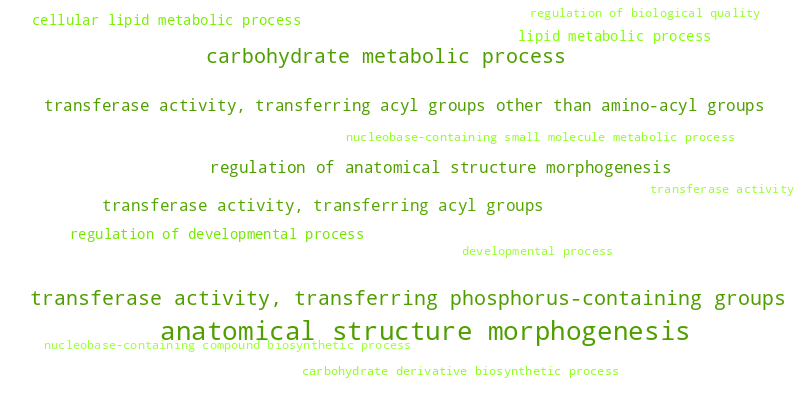

In [17]:
wc = WordCloud(
    background_color="white",
    color_func = color_func,
    relative_scaling = 1,
    max_words = 15,
    scale = 2,
)

wc.generate_from_frequencies(frequencies)
wc.to_file("../figs/wordcloud.pdf")
wc.to_image()